In [1]:
# import the libraries we need
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# Dataset

In [2]:
# import the dataset from tensorflow_datasets
(train_ds, test_ds), info = tfds.load('genomics_ood', split=['train', 'test'], as_supervised=True, with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='genomics_ood',
    version=0.0.1,
    description='Bacteria identification based on genomic sequences holds the promise of early
detection of diseases, but requires a model that can output low confidence
predictions on out-of-distribution (OOD) genomic sequences from new bacteria
that were not present in the training data.

We introduce a genomics dataset for OOD detection that allows other researchers
to benchmark progress on this important problem. New bacterial classes are
gradually discovered over the years. Grouping classes by years is a natural way
to mimic the in-distribution and OOD examples.

The dataset contains genomic sequences sampled from 10 bacteria classes that
were discovered before the year 2011 as in-distribution classes, 60 bacteria
classes discovered between 2011-2016 as OOD for validation, and another 60
different bacteria classes discovered after 2016 as OOD for test, in total 130
bacteria classes. Note that training, validation, 

In [3]:
# have a look at some example datapoints
tfds.as_dataframe(train_ds.take(5), info)

,label,seq
0,7 (Staphylococcus),AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT
1,5 (Pseudomonas),CACAGCCGGCCGCTGACCTGCTGGCCATCGGAGCGCTGGCCGGCCTCGAGGATATTGGCCAGCAGCAGGTGGATGTCTCGGGCATAGCGCTCCCCCTGGTAGGTGATGCGAATGCTGCGGCCCTGGCGCTCGGTCAGGGCAAAACCCAGGGTCTGCTCCAGGCTCTTGATCTGGTGGCTGATGGCGCTGGGCGTCAGGTTCAGCTCATTGGCGGCCTCGGCGACACTGCCCAGGCGGGCCACCGCGTCCA
2,1 (Burkholderia),CGCCGGCACCGTTGCTGGCCAAAATCGCCGAGCGTCCGGATGCCGGCATGCATCGTGAATCGTCTTATCTGAAATGGCACTGGCGCGTTTGCCGGGAACTTCTCCAACGTCGGGAGCACGGGGCAACTCATGGCTAAACTCATCGTGGGCAACGTCGATAACGAAGCAATGATCGGGGACACGAAGCGTGCATCGCTTCCGCTTCGCCAGGTATCAGCGATTGCAGCAAGGCGCCTCGTCTGGCAGATGA
3,5 (Pseudomonas),GCAGGTGCTGTTGGCCGGCACCAACCACCACATCCGCCTGCTGCAGAATGGCCAGCTGGCCTACACTGCCGAGCCGGTCAACGAAATCTATCGGCCTTCGATCGATGTGTTCTTCGAAAGCGTCGCGCGCTATTGGTCGGGCGATGCGGTGGGCGTGCTGCTCACCGGCATGGGCCGCGATGGTGCCCAGGGCCTGAAGCTGATGCGCCAGCAGGGCTTCCTGACCATCGCCCAGGACCAGCAGAGCAGC
4,6 (Salmonella),TCCGGACGCCAATTTATTACCGGTAAGAAAAGCGAACTCACCTAATTTTACGGTCTGGTGACCAGAACCGACCGCACGCAAAAGCTTCTGAACCGATGAGGATGCTATGGGAAACACAACAATACAAACGCAGAGTTTTCGTGCTGTGGATGCAGAGCAAAGCAAGAGCAAGCGCTACATTATTCCATTCGCCTTACTTTGCTCGCTATTTTTTCTGTGGGCTGTCGCCAATAATCTGAATGACATTTTA


In [4]:
# check the structure of a single tensor
for elem in train_ds.take(1):
  for e in elem:
    print(e)

tf.Tensor(b'AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT', shape=(), dtype=string)
tf.Tensor(7, shape=(), dtype=int64)


In [5]:
# function to transform the genomic sequence string to one-hot-vectors for encoding the nucleotides (A, C, G, T)
def onehotify(tensor):
  vocab = {'A':'1', 'C': '2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

In [6]:
# function to prepare the dataset
def prepare_genomics_data(ds):
  # create one-hot sequences
  ds = ds.map(lambda seq, target: (onehotify(seq), target))
  # create one-hot targets
  ds = ds.map(lambda seq, target: (seq, tf.one_hot(target, depth=10)))
  # shuffle, batch and prefetch the data
  ds = ds.shuffle(1000).batch(25).prefetch(20)
  return ds

In [7]:
# use 100.000 examples for training and 1.000 for testing
train_ds = train_ds.take(100000)
test_ds = test_ds.take(1000)

In [8]:
# prepare the training and the test dataset
train_dataset = train_ds.apply(prepare_genomics_data)
test_dataset = test_ds.apply(prepare_genomics_data)


In [9]:
# let's inspect the respective shapes again after preparing the data 
for a, b in train_dataset.take(1):
  print(a)
  print(b)

tf.Tensor(
[[1. 0. 0. ... 1. 0. 0.]
 [1. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [1. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]], shape=(25, 1000), dtype=float32)
tf.Tensor(
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 

# Model

In [10]:
# Custom Layer
class SimpleDense(tf.keras.layers.Layer):

    def __init__(self, units, activation):
        super(SimpleDense, self).__init__()
        self.units = units
        self.activation = activation

    def build(self, input_shape): 
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                               initializer='random_normal',
                               trainable=True)
        self.b = self.add_weight(shape=(self.units,),
                               initializer='random_normal',
                               trainable=True)

    def call(self, inputs): 
        x = tf.matmul(inputs, self.w) + self.b
        x = self.activation(x)
        return x

In [11]:
# Custom Model
class MyModel(tf.keras.Model):
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid) # 1st hidden layer with 256 units
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.sigmoid) # 2nd hidden layer with 256 units
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax) # output layer with 10 units

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

# Training function

In [12]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = tf.reduce_mean(test_loss_aggregator)
  test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

# Training and visualization

In [13]:
tf.keras.backend.clear_session()

# Hyperparameters
num_epochs = 10
learning_rate = 0.1

# Initialize the model
model = MyModel()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: SGD with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# Testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs
for epoch in range(num_epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # Training (and checking in with training)
    epoch_loss_agg = []
    for input,target in train_dataset:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)
    
    # Track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # Testing, so we can track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: 0 starting with accuracy 0.093
Epoch: 1 starting with accuracy 0.318
Epoch: 2 starting with accuracy 0.368
Epoch: 3 starting with accuracy 0.34500000000000003
Epoch: 4 starting with accuracy 0.378
Epoch: 5 starting with accuracy 0.366
Epoch: 6 starting with accuracy 0.379
Epoch: 7 starting with accuracy 0.35300000000000004
Epoch: 8 starting with accuracy 0.358
Epoch: 9 starting with accuracy 0.348


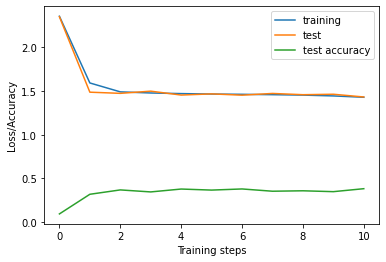

In [14]:
# Visualize accuracy and loss for training and test data
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
line3, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Loss/Accuracy")
plt.legend((line1,line2, line3),("training","test", "test accuracy"))
plt.show()